In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 256#512
nSimTime = 256*100#2048
nTime = nLat
lSim = 0
nSims = 100

phi0 = 1.; print('phi0 = ', phi0)
m2eff = 1.
lenLat = 100.;
phi_initial = 0
nCols = 2

nyq = nLat//2; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 8.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)

phi0 =  1.0
dx, dk, spec  0.390625 0.06283185307179587 128
dtout/dt =  1.0
light_cone =  0


### Theoretical Field PS 

### Extract data from files

In [4]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'

sim_location = lambda nT, nL, tem, phi, lam, m2, ktr, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_m2{:.4f}'.format(m2)+'_kchange'+str(ktr)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, m2, ktr, gam, tem: '_for_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_m2{:.4f}'.format(m2)+'_kchange'+str(ktr)+'_gam{:.4f}'.format(gam)

In [5]:
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))
list_thresh = lambda tem, sigma: np.arange(1, 500)/100*sigma0_th(tem, sigma)

def extract_sim(nT, nL, tem, phi, lam, m2, ktr, gam, sim, sigma=0.):
    data = np.genfromtxt(sim_location(nSimTime, nL, tem, phi, lam, m2, ktr, gam, sim))
    simulation = [[]]*nCols
    for col in range(nCols):
        simulation[col] = np.reshape(data[:,col], (nT, nL))
    if sigma != 0:
        for col in range(nCols):
            simulation[col] = np.asarray([smoothen(slic, sigma) for slic in simulation[col]])
    return np.asarray(simulation)[-nL:]

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [6]:
m2eff = 1.
lamb = 1.
gamma = 0.
list_temp = np.arange(10, 81, 10)/10.; print(list_temp)

filter_size = 0.

[1. 2. 3. 4. 5. 6. 7. 8.]


In [7]:
all_data = np.asarray([[extract_sim(nTime, nLat, temp, phi0, lamb, m2eff, 5, gamma, sim, filter_size) for sim in range(lSim, nSims)] for temp in list_temp])

In [8]:
np.shape(all_data)

(8, 100, 2, 256, 256)

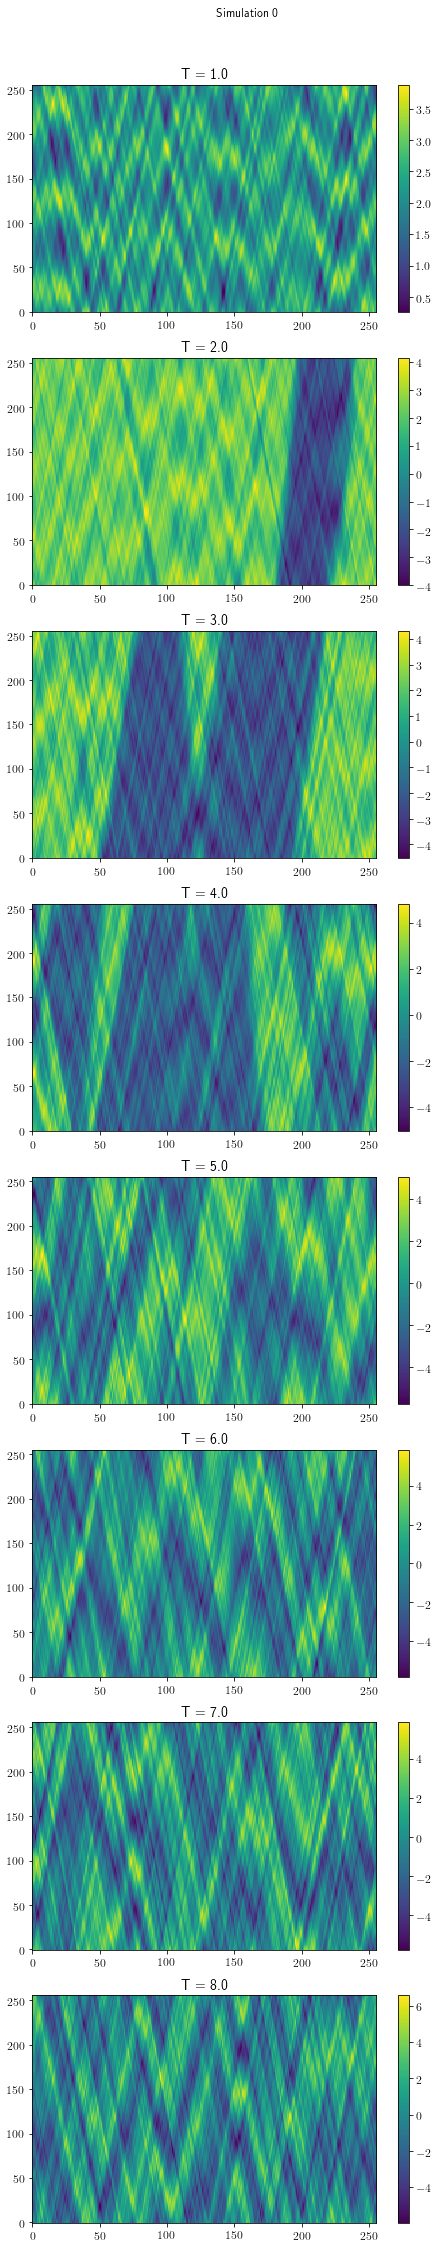

In [9]:
for sim in range(0, nSims, nSims):
    fig, ax = plt.subplots(len(list_temp), 1, figsize = (4*1+4, 4*len(list_temp)+4))
    for temp in range(len(list_temp)):
            im0 = ax[temp].imshow(all_data[temp][sim][0], aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im0, ax = ax[temp])
            ax[temp].set_title('T = '+str(list_temp[temp]))
    plt.suptitle('Simulation '+str(sim))
    plt.show()

In [10]:
# track ktrack mode amplitude across time

In [11]:
# field spectrum
# prediction from lattice renormalization

norm = lambda phi: 1./ phi / np.sqrt(lenLat)
freqs1 = dk * np.asarray(np.arange(-nLat/2,1).tolist() + np.arange(1,nLat/2).tolist()) 
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
omega = lambda m2: np.sqrt(freqs**2. + m2)
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda phi, m2, tem: norm(phi) * np.sqrt(2./(np.exp(omega(m2)/tem) - 1.)) / np.sqrt(2.*omega(m2))
pspec = lambda phi, m2, tem, sigma: np.abs(spectral_field(phi, m2, tem) * Filter(sigma))**2.
sigma0_th = lambda phi, m2, tem, sigma: np.sqrt(np.sum(pspec(phi, m2, tem, sigma)))

V = lambda x, m2, lam: - 0.5 * m2 * x**2. + lam * x**4. / 24.
VVVV = lambda lam: lam

deltam2 = lambda phi, lam, m2, tem, sigma: 0.5 * VVVV(lam) * np.sum(pspec(phi, m2, tem, sigma))

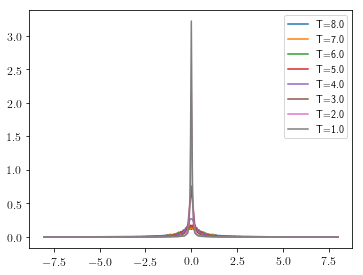

In [12]:
# frequencies at initialization

plt.figure()
for temp in range(len(list_temp))[::-1]:
    modeamp = []
    for sim in range(nSims-lSim):
        simulation = all_data[temp][sim][0]
#        simulation = simulation - np.mean(simulation)
        T, N = simulation.shape                
        modeamp.append(np.abs(np.fft.fftshift(np.fft.fft(simulation[0])))**2.)
    plt.plot(freqs, np.mean([modeamp[sim]/nLat**2. for sim in range(len(modeamp))], axis=0), label='T='+str(list_temp[temp]))
plt.legend(); plt.show()

In [13]:
print(np.shape(all_data)) # (temperature, simulation, column, time, space)

# this stuff won't work unless simulation starts at initalization

ktrack = []
for temp in range(len(list_temp)):
    for sim in range(nSims-lSim):
        simulation = all_data[temp][sim][0]
        fftt0slice = np.abs(np.fft.fft(simulation[0]))
        ktrack.append(np.argmax(fftt0slice))

print(int(np.round(np.mean(ktrack))))
ktrack = 4; print(ktrack)

absktrack = []
for temp in range(len(list_temp)):
    for sim in range(nSims-lSim):
        simulation = all_data[temp][sim][0]
        fftt0slice = np.fft.fftshift(np.abs(np.fft.fft(simulation[0])))
        absktrack.append(np.argmax(fftt0slice))

print(int(np.round(np.mean(absktrack))))
absktrack = 124; print(absktrack)

(8, 100, 2, 256, 256)
25
4
127
124


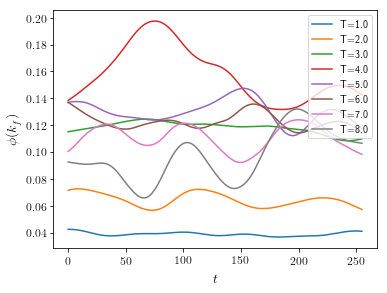

In [14]:
# time evolution of ktrack 
plt.figure()
for temp in range(len(list_temp)):
    modeamp = np.asarray([[np.abs(np.fft.fft(all_data[temp][sim][0][timeslice])[ktrack])**2./N**2. for timeslice in range(T)] for sim in range(nSims-lSim)])
    plt.plot(np.arange(T), np.mean(modeamp, axis=0), label='T='+str(list_temp[temp]))
plt.xlabel(f'$t$'); plt.ylabel(f'$\phi(k_f)$'); plt.legend(); plt.show()

In [15]:
# get mass best fit
omega_fit = lambda k, a, m: a*k + m

multiplier = 2
def get_masses(kcut):
    masses = np.asarray([[[0.]]*all_data.shape[1]]*all_data.shape[0])
    msq_ktrack = np.asarray([[[0.]]*all_data.shape[1]]*all_data.shape[0])
    for temp in range(len(list_temp)):
        for sim in range(nSims-lSim):
            #print(m2, lam, temp, sim)
            simulation = all_data[temp][sim][0]
            simulation = simulation - np.mean(simulation)
            simulation = np.asarray([np.fft.ifft([np.fft.fft(simulation[timeslice])[i] if (i < kcut or i > N-kcut) else 0. for i in range(N)]) for timeslice in range(T)])
            simulation = simulation - np.mean(simulation)

            kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
            oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
            #k = np.fft.fftshift(np.fft.fftfreq(N))*N
            #o = np.fft.fftshift(np.fft.fftfreq(T))*T

            pspec_sim = np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2./N**2./T**2.
            #pspec_sim[T//2, :]= 0.
            #pspec_sim[:, absktrack] = 0.
            #pspec_sim[:, N//2]= 0.
            maxVal = np.mean(pspec_sim) + multiplier * np.std(pspec_sim)
            osccoords = np.argwhere(pspec_sim > maxVal)

            try:
                popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2.)
                masses[temp][sim] = popt[-1]
                msq_ktrack[temp][sim] = omega_fit(kk[absktrack]**2,*popt)

                if masses[temp][sim] < 0:
                    masses[temp][sim] = 'nan'
                    msq_ktrack[temp][sim] = 'nan'

            except TypeError:
                masses[temp][sim] = 'nan'
                msq_ktrack[temp][sim] = 'nan'
                continue

            if sim == 0.1:
                lim = 5
                plt.figure()
                im = plt.imshow(pspec_sim>maxVal, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                plt.plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=2, label='freqs')
                plt.plot(kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2., 'o', ms=2, label='freqs sq')
                plt.plot(kk, np.sqrt(omega_fit(kk**2.,*popt)), label='m=%5.5f'%np.sqrt(popt[-1]))
                plt.plot(kk, omega_fit(kk**2.,*popt), label=f'$m^2=$%5.5f'%popt[-1])
                plt.ylim(0,lim); plt.xlim(-lim,lim)
                plt.axhline(np.sqrt(popt[-1]), color='darkgray', ls='-.')
                plt.axhline(popt[-1], color='darkgray', ls='-.')
                plt.legend(); plt.show()

                fig, ax = plt.subplots(1, 1, figsize = (8, 4))
                ax.plot(kk[absktrack], np.sqrt(omega_fit(kk[absktrack]**2,*popt)), linestyle='None', marker='*', ms=10, color='y')
                ax.plot(kk[absktrack + 2*(N//2 - absktrack)], np.sqrt(omega_fit((kk[absktrack + 2*(N//2 - absktrack)])**2,*popt)), linestyle='None', marker='*', ms=10, color='y')
                ax.plot(kk, np.sqrt(omega_fit(kk**2.,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
                im = ax.imshow(pspec_sim, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                clb = plt.colorbar(im, ax = ax)
                ax.set_title('Sim '+str(sim)+': T = '+str(list_temp[temp]))
                plt.xlabel(r'$\bar{k}$')
                plt.ylabel(r'$\bar{\omega_k}$')
                plt.xlim(-lim,lim)
                plt.ylim(-T/N*lim,T/N*lim)
                plt.axvline(0, color='darkgray', ls='-.')
                plt.axhline(0, color='darkgray', ls='-.')
                plt.legend(); plt.show()
    return masses, msq_ktrack

[128.  64.  32.  16.   8.]
2.0


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


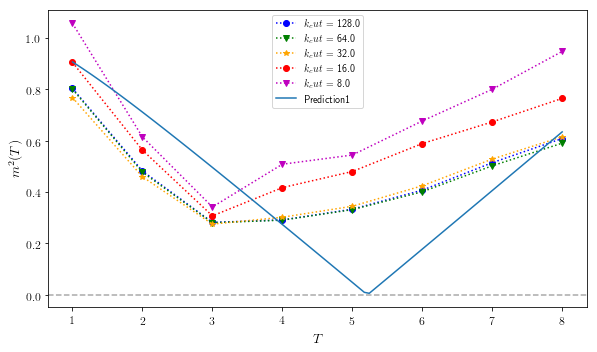

In [16]:
fine_temp_list = np.linspace(min(list_temp), max(list_temp), 100)
kcut_list = 2.**np.arange(3, 8, 1)[::-1]; print(kcut_list)

colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v', '*'))

m2 = 2*m2eff; print(m2)
m2bare = -m2eff
mthermal2 = lambda tem: (lamb/24.) * tem**2.

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for kcut in kcut_list[::]:
    mark = next(marks)
    col = next(colors)
    masses, msq_ktrack = get_masses(kcut)
    mean_masses = np.ndarray.flatten(np.nanmean(masses, axis=1))
    mass_mode = np.ndarray.flatten(np.nanmean(msq_ktrack, axis=1))
    th_masses1 = np.asarray([m2bare+deltam2(phi0, lamb, m2eff, tem, filter_size) for tem in fine_temp_list])
    #th_masses2 = np.asarray([m2+mthermal2(tem)+deltam2(phi0, lamb, m2eff, tem, filter_size) for tem in fine_temp_list])

    plt.plot(list_temp, mean_masses, marker=mark, linestyle=':', color=col, label=f'$k_cut$ = '+str(kcut))
#    plt.plot(list_temp, mass_mode, marker=mark, linestyle='--', color=col, label='Mass of rogue mode')

plt.plot(fine_temp_list, np.abs(th_masses1), label='Prediction1')
plt.axhline(0, color='darkgray', ls='--')
plt.ylabel(f'$m^2(T)$'); plt.xlabel(f'$T$')
plt.legend(); plt.show()